## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df.query("landing_page == 'new_page' and group == 'control'").count()[0] + df.query("landing_page == 'old_page' and group == 'treatment'").count()[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
dfa = df.drop(df[(df.landing_page == 'new_page') & (df.group == 'control')].index)

In [9]:
df2 = dfa.drop(dfa[(dfa.landing_page == 'old_page') & (dfa.group == 'treatment')].index)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
pd.concat(g for _, g in df2.groupby("user_id") if len(g) > 1)

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [108]:
pd.concat(g for _, g in df2.groupby("user_id") if len(g) > 1)

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.drop_duplicates('user_id',inplace=True)
df2.shape

(290584, 5)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2["converted"].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
p_given_c = df2.query("converted == 1 and group == 'control'").count()[0]/df2.query("group == 'control'").count()[0]
p_given_c

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
p_given_t = df2.query("converted == 1 and group == 'treatment'").count()[0]/df2.query("group == 'treatment'").count()[0]
p_given_t

0.11880806551510564

In [17]:
#observed difference
obs_diff = p_given_t - p_given_c
obs_diff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [18]:
df2.query("landing_page == 'new_page'").count()[0]/df2.shape[0]

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**There is not sufficient evidence from these answers to conclude that the new treatment page leads to more conversions because the probabilities appear to be close with the control page resulting in higher probability.  Additionally, we have yet to run any analysis to test for effects of Simpson's rule**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Null hypothesis:  The mean conversion rate of the new page minus the mean conversion rate of the old page is less than or equal to zero.
Alternative hypothesis:  The mean conversion rate of the new page minus the mean conversion rate of the old page is greater than zero.**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
n_new = df2.query("group == 'treatment'").count()[0] 
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
n_old = df2.query("group == 'control'").count()[0] 
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.choice([0,1], size = n_new, p = [(1-p_new), p_new], replace = True)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.choice([0,1], size = n_old, p = [(1-p_old), p_old], replace = True)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
p_new_less_p_old = new_page_converted.mean() - old_page_converted.mean()
p_new_less_p_old

0.0019732622375661507

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [26]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([0,1], size = n_new, p = [(1-p_new), p_new], replace = True)
    old_page_converted = np.random.choice([0,1], size = n_old, p = [(1-p_old), p_old], replace = True)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

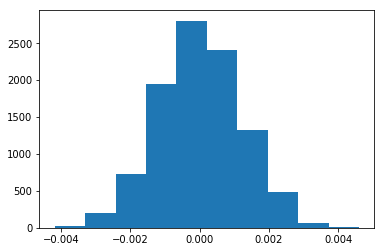

In [27]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

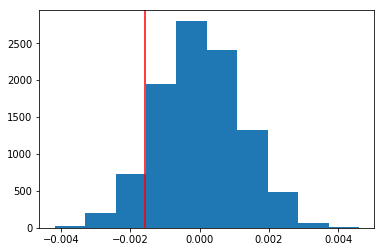

In [28]:
plt.hist(p_diffs)
plt.axvline(obs_diff, c='red');

In [29]:
(p_diffs > obs_diff).mean()

0.90720000000000001

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**In part j, I have calculated the p-value; that is the probablity of observing the statistic if the null hypothesis is true.  In this instance, we have a large p-value which indicates we fail to reject the null hypothesis and agree that the statistic could have been sampled from a population where the mean conversion rate of the new page minus the mean conversion rate of the old page is less than or equal to zero **

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
import statsmodels.api as sm

convert_old = sum((df2.group == 'control') & (df2.converted == 1))
convert_new = convert_new = sum((df2.group == 'treatment') & (df2.converted == 1))
n_old = sum(df2.group == 'control')
n_new = sum(df2.group == 'treatment')

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [31]:
zstat, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
zstat, p_value

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**This z-score indicates the observed difference is -1.31 standard deviations in the normal distribution of the null hypothesis and the p-value is consistent with my previous computation, indicating 90% probability of observing the statistic given the null hypothesis is true.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [33]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [34]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-09-07 14:46 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**We are now performing a two-sided test, and considering our null hypothesis as the mean conversion rate of the new page minus the mean conversion rate of the old page is zero and the alternative hypothesis to be the mean conversion rate of the new page minus the mean conversion rate of the old page is not zero.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Adding other factors to the regression model may help us identify a factor that does have a significant impact upon the conversion rate.  However, we do run the risk of collinearity making our results unreliable**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?

In [35]:
countries_df = pd.read_csv('countries.csv')
countries_df['US'] = pd.get_dummies(countries_df['country'])['US']
countries_df['UK'] = pd.get_dummies(countries_df['country'])['UK']
countries_df.head()

,user_id,country,US,UK
0,834778,UK,0,1
1,928468,US,1,0
2,822059,UK,0,1
3,711597,UK,0,1
4,710616,UK,0,1


In [36]:
#Create Dataframe by joining 'countries_df' and 'df2' on "user_id"
df_all = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_all.head()

,country,US,UK,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,,,
834778,UK,0,1,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,1,0,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,0,1,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,0,1,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,0,1,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [37]:
log_mod = sm.Logit(df_all['converted'], df_all[['intercept', 'ab_page', 'US', 'UK']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-09-07 14:46 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
==================================================================

"""

**Adding the country variables to our model results in high p-values, over 0.05, indicating the country alone does not significantly impact conversion rate.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [38]:
#create additional columns comparing both group and country together
df_all['ab_page_US'] = df_all['ab_page']*df_all['US'] 
df_all['ab_page_UK'] = df_all['ab_page']*df_all['UK']
df_all.head()

,country,US,UK,timestamp,group,landing_page,converted,intercept,ab_page,ab_page_US,ab_page_UK
user_id,,,,,,,,,,,
834778,UK,0,1,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,0
928468,US,1,0,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,1,0
822059,UK,0,1,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,0,1,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,0
710616,UK,0,1,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [43]:
log_mod = sm.Logit(df_all['converted'], df_all[['intercept', 'ab_page', 'US', 'UK', 'ab_page_US', 'ab_page_UK']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-09-07 15:10 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
ab_page_US     0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
ab_page_UK     0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
==================================================================

"""

In [51]:
#how long did the experiment run?
df_all['date'] = df_all['timestamp'].str[:10]
df_all.groupby(['date']).mean()

,US,UK,converted,intercept,ab_page,ab_page_US,ab_page_UK
date,,,,,,,
2017-01-02,0.705182,0.240896,0.122724,1.0,0.499475,0.347864,0.124650
2017-01-03,0.697683,0.253937,0.113795,1.0,0.501060,0.350469,0.126514
2017-01-04,0.706609,0.242701,0.119293,1.0,0.498590,0.350484,0.122418
2017-01-05,0.697263,0.251933,0.119084,1.0,0.503016,0.351763,0.125657
2017-01-06,0.695424,0.253052,0.119449,1.0,0.505280,0.350034,0.129259
2017-01-07,0.700068,0.251041,0.118595,1.0,0.500189,0.348747,0.125331
2017-01-08,0.694181,0.257787,0.119818,1.0,0.500486,0.344513,0.131097
2017-01-09,0.693498,0.255682,0.118855,1.0,0.499509,0.345390,0.127992
2017-01-10,0.693034,0.257678,0.119625,1.0,0.501573,0.346367,0.128839


**Adding the country-page interaction variables to our model still results in high p-values, over 0.05, indicating the country-page interaction does not significantly impact conversion rate and we fail to reject the null hypothesis.  The experiment data covers three weeks; perhaps this is not enough to overcome novelty and change aversion factors and a longer experiment might yeild more significant results.**

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [52]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0